In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from scipy.integrate import simpson 
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
import prodimopy.read as pread
import prodimopy.plot as pplot
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
@njit
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def plot_prodimo_specie(dataframe, specie, xrange=(5, 28), num_xticks=5, yrange=(0, 0.02), num_yticks=5, savename=None):
    '''
    Plots the spectrum of a specific specie for all the models
    '''
    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    for i, row in dataframe.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['Prodimo Wavelength'], row[f'ProDiMo {specie}'], label=row['Model Name'])
        axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.8,
                     f"C={row['C Value']} O={row['O Value']} CO={row['CO Value']} \nFlux={total_flux(row['Prodimo Wavelength'], row[f'ProDiMo {specie}']):.1e}",
                     fontsize=10, color='red',
                     weight='bold')
        axes[i].set_xlim(xrange)
        axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            axes[i].set_yticks(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
            axes[i].set_yticklabels(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
    fig.suptitle(specie, fontsize=30, fontweight='bold', y=1.02)
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()


def plot_FLiTs_spec(df, xrange=(5, 28), num_xticks=5, yrange=(0, 0.12), num_yticks=5, savename=None):
    '''
    Plots the spectrum of a specific specie for all the models
    '''
    fig = plt.figure(figsize=(13, 13))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    for i, row in df.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux'], label=row['Model Name'])
        axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.8,
                     f"C={row['C Value']} O={row['O Value']} C/O={row['CO Value']}",
                     fontsize=10, color='red',
                     weight='bold')
        axes[i].set_xlim(xrange)
        axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            axes[i].set_yticks(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
            axes[i].set_yticklabels(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()


def plot_prodimo_spec(df, model,
                      species=('C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'o-H2', 'o-H2O',
                               'p-H2', 'p-H2O', 'Ion'), xrange=(5, 28), yrange=(0, 0.04), plotFLiTs=False):
    """
    Plots the total spectrum predicted by prodimo
    """
    total_spec = None
    cmap = mpl.colormaps.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(14, 5))
    for index, specie in enumerate(species):
        if total_spec is None:
            total_spec = df.loc[df['Model Name'] == model, f'ProDiMo {specie}'].values[0].copy()
        else:
            total_spec += df.loc[df['Model Name'] == model, f'ProDiMo {specie}'].values[0].copy()
        ax.fill_between(df['Prodimo Wavelength'][0], 0, total_spec, label=specie, zorder=len(species) - index,
                        color=cmap(index / len(species)))
    if plotFLiTs:
        ax.plot(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(),
                df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), label='FLiTs', color='black',
                zorder=20)
    fig.suptitle(model)
    ax.set_ylabel('Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.legend(loc='best')
    plt.show()


def plot_flits_specie(specie):
    data = []
    for model in df['Model Name'].copy():
        info = []
        info.append(model)
        model_flits = pread.read_FLiTs(f'./FLiTs/{specie}/' + model, filename=f'specFLiTs1_{specie}.out')
        info.append(model_flits.wl)
        info.append(model_flits.flux - model_flits.flux_cont)
        data.append(info)

    specie_df = pd.DataFrame(data, columns=['Model Name', 'FLiTs Wavelength', 'FLiTs Flux'])
    fig = plt.figure(figsize=(13, 13))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    xrange = [5, 28]
    yrange = [0, .1]
    num_xticks = 5
    num_yticks = 5
    for i, row in specie_df.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux'], label=row['Model Name'], lw=1)
        # axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,
        #              row['Model Name'],
        #              fontsize=10, color='red',
        #              weight='bold')
        axes[i].set_xlim(xrange)
        # axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            # axes[i].set_yticks(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
            # axes[i].set_yticklabels(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
    plt.tight_layout()
    plt.savefig(f'./figures/{specie}_FLiTs.pdf')
    plt.show()


@njit
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


def plot_lineorigin(model, specie_with_wl: list):
    pp = pplot.Plot(None)
    cbticks = [10, 30, 100, 300, 1000]
    fig = pp.plot_line_origin(model, specie_with_wl, field=model.tg,
                              label=r"$\mathrm{T_{gas}\,[K]}$", zlim=[5, 5e3], extend="both", cb_format="%.0f", zr=True,
                              xlog=True,
                              xlim=[None, 0.2], ylim=[None, 0.2],
                              clevels=cbticks,  # explictly set ticks for the cbar
                              clabels=map(str, cbticks),
                              showContOrigin=False, showRadialLines=False)  # this adds an additional contour
    plt.tight_layout()

In [3]:
model_path = './models/C_0.0_O_0.5_CO_0.145'
model = pread.read_prodimo(model_path)

READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\FlineEstimates.out  ...


KeyboardInterrupt: 

In [ ]:
plt.close('all')
plot_lineorigin(model, [['NH3_H', 8.24]])
# plt.savefig('NH3_lineorigin.png')

In [2]:
# Open the data 
with open('ModelData.pkl', 'rb') as f:
    df = pickle.load(f)

df.head()

,Model Name,C Value,O Value,CO Value,FLiTs Wavelength,FLiTs Flux,ProDiMo C2H2_H,ProDiMo CH4_H,ProDiMo CO,ProDiMo CO2_H,...,FLiTs HCN Flux,FLiTs HCN Wavelength,FLiTs NH3 Flux,FLiTs NH3 Wavelength,FLiTs NO Flux,FLiTs NO Wavelength,FLiTs O2 Flux,FLiTs O2 Wavelength,FLiTs OH Flux,FLiTs OH Wavelength
0,C_-0.5_O_-0.5_CO_0.45,-0.5,-0.5,0.45,"[4.90216873, 4.90218508, 4.90220144, 4.9022177...","[9.290666707434392e-05, 9.36347640732027e-05, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.952423092712322e-05, 0.0014063230855588184,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[6.378495697283822e-07, 6.387100352244269e-07,...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-5.8350389491046706e-21, -5.03439622287413e-2...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[3.0270818583376225e-06, 3.139984831089091e-06...","[4.94498186, 4.94499836, 4.94501485, 4.9450313...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.82143071, 5.82145013, 5.82146955, 5.8214889...","[1.0257065809962212e-09, 1.0500830885569483e-0...","[5.04256821, 5.04258503, 5.04260185, 5.0426186..."
1,C_-0.5_O_-0.25_CO_0.2570,-0.5,-0.25,0.2570,"[4.90218508, 4.90220144, 4.90221779, 4.9022341...","[0.00019233132506346617, 0.0001931775592640128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.813929078924544e-05, 0.0015757262036912984,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[5.068377706716017e-07, 5.073831905948671e-07,...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-5.618665761386699e-21, -2.8157538949700815e-...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[2.763403199084484e-06, 2.855910825837657e-06,...","[4.94499836, 4.94501485, 4.94503135, 4.9450478...","[-2.1707895192379586e-27, -2.193236249939068e-...","[5.82145013, 5.82146955, 5.82148897, 5.8215083...","[1.2735189310214756e-09, 1.304640496669032e-09...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
2,C_-0.5_O_0.0_CO_0.145,-0.5,0.0,0.145,"[4.90221779, 4.90222315, 4.9022395, 4.90225585...","[0.000367419622368359, 0.0003677125852135088, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.681364981246149e-05, 0.0017475277674422628,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[3.558295577105443e-07, 3.5618463561068564e-07...","[6.28443468, 6.28445564, 6.2844766, 6.28449757...","[-5.322838505691836e-21, -5.945672260346973e-2...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[2.5292308540110307e-06, 2.6050974120929887e-0...","[4.94501485, 4.94503135, 4.94504784, 4.9450643...","[-3.9283973436739766e-27, -3.9530125523498256e...","[5.82148897, 5.82150839, 5.82152781, 5.8215472...","[2.078079491400748e-09, 2.1210007757111804e-09...","[5.04258503, 5.04260185, 5.04261867, 5.0426354..."
3,C_-0.5_O_0.25_CO_0.0813,-0.5,0.25,0.0813,"[4.9022395, 4.90225585, 4.9022722, 4.90228855,...","[0.0006806647851314573, 0.0006815528527352455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.549685101642894e-05, 0.0019219163659186743,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[2.4586606938847583e-07, 2.4621352971123114e-0...","[6.28445564, 6.2844766, 6.28449757, 6.28451853...","[-1.0994571515600186e-21, 0.0, -5.621684263107...","[4.92189765, 4.92191407, 4.92193049, 4.9219469...","[1.6157067910015946e-06, 1.6620520338955752e-0...","[4.94503135, 4.94504784, 4.94506434, 4.9450808...","[1.0052181291598129e-26, 9.84469149236727e-27,...","[5.82150839, 5.82152781, 5.82154722, 5.8215666...","[2.173647823316478e-09, 2.2209748503133934e-09...","[5.04261867, 5.04263549, 5.04265231, 5.0426691..."
4,C_-0.5_O_0.5_CO_0.045,-0.5,0.5,0.045,"[4.90225585, 4.9022722, 4.90228855, 4.90230491...","[0.001111040302178401, 0.001111295774154919, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [4]:
string = 'curl -u niels:grid1brp'
for name in df['Model Name']:
    string += ' -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/'+name+'.tar.gz'
print(string)

curl -u niels:grid1brp -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.5_O_-0.5_CO_0.45.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.5_O_-0.25_CO_0.2570.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.5_O_0.0_CO_0.145.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.5_O_0.25_CO_0.0813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.5_O_0.5_CO_0.045.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.25_O_-0.5_CO_0.813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.25_O_-0.25_CO_0.45.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.25_O_0.0_CO_0.257.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.25_O_0.25_CO_0.145.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_-0.25_O_0.5_CO_0.0813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_0.0_O_-0.5_CO_1.445.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000/C_0.0_O_

# Escape Probability

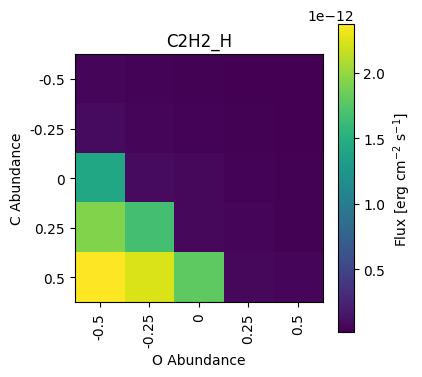

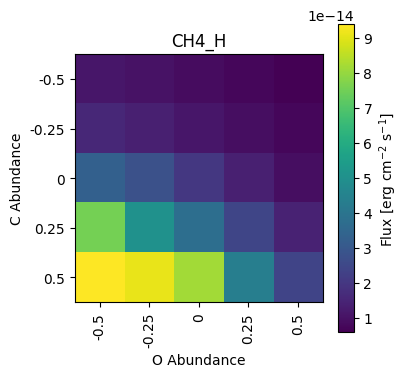

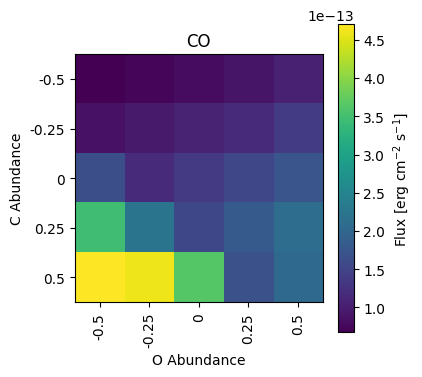

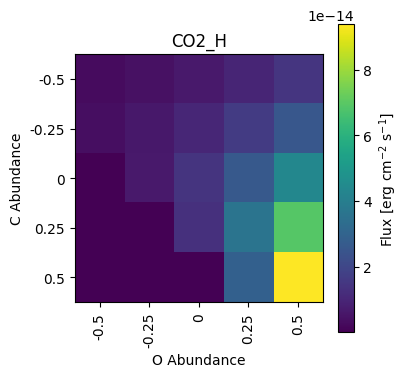

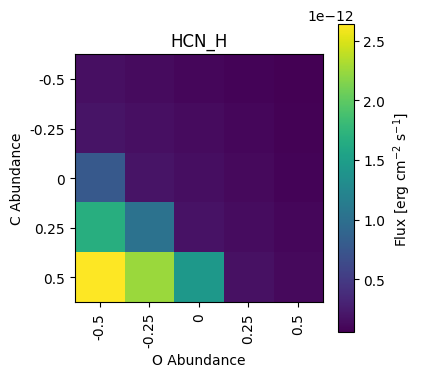

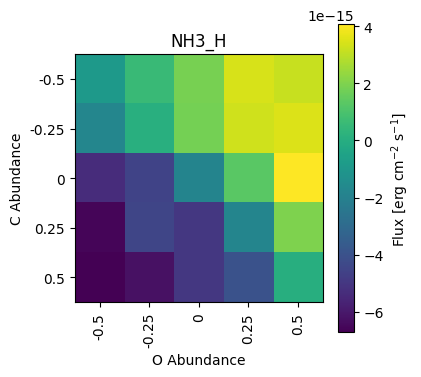

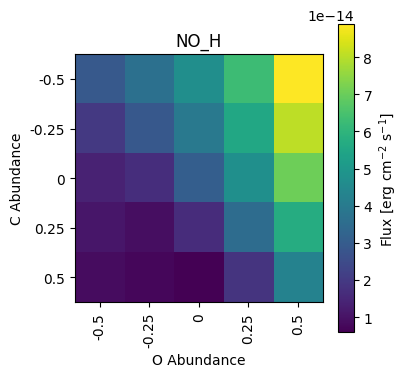

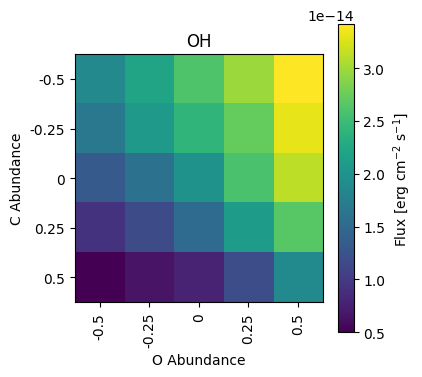

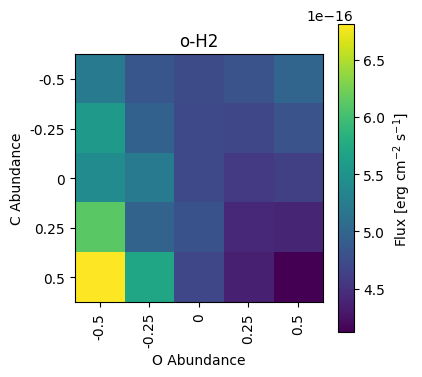

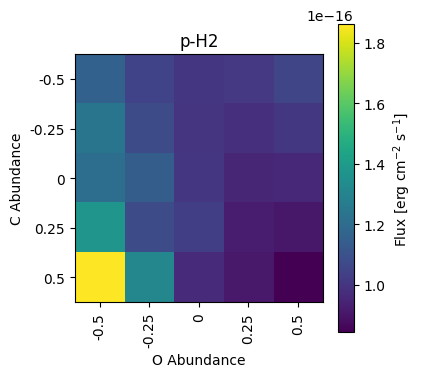

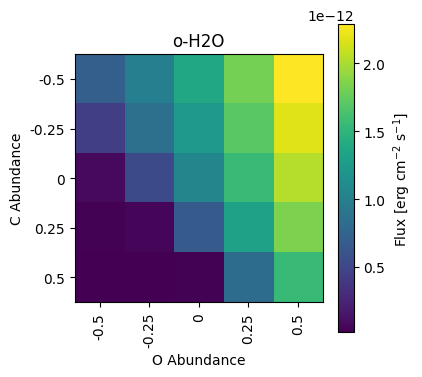

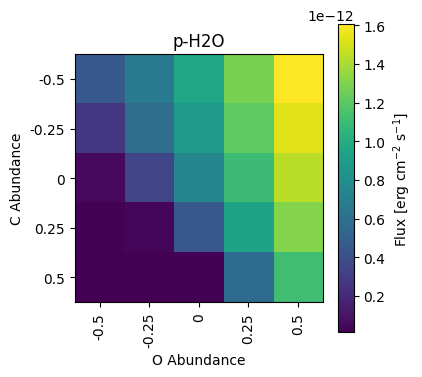

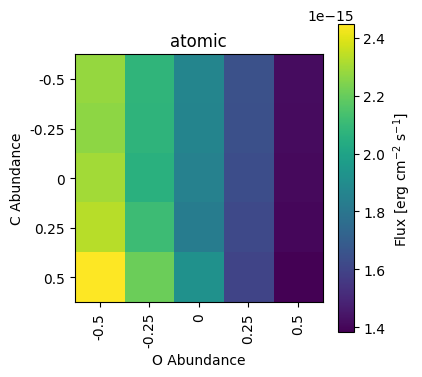

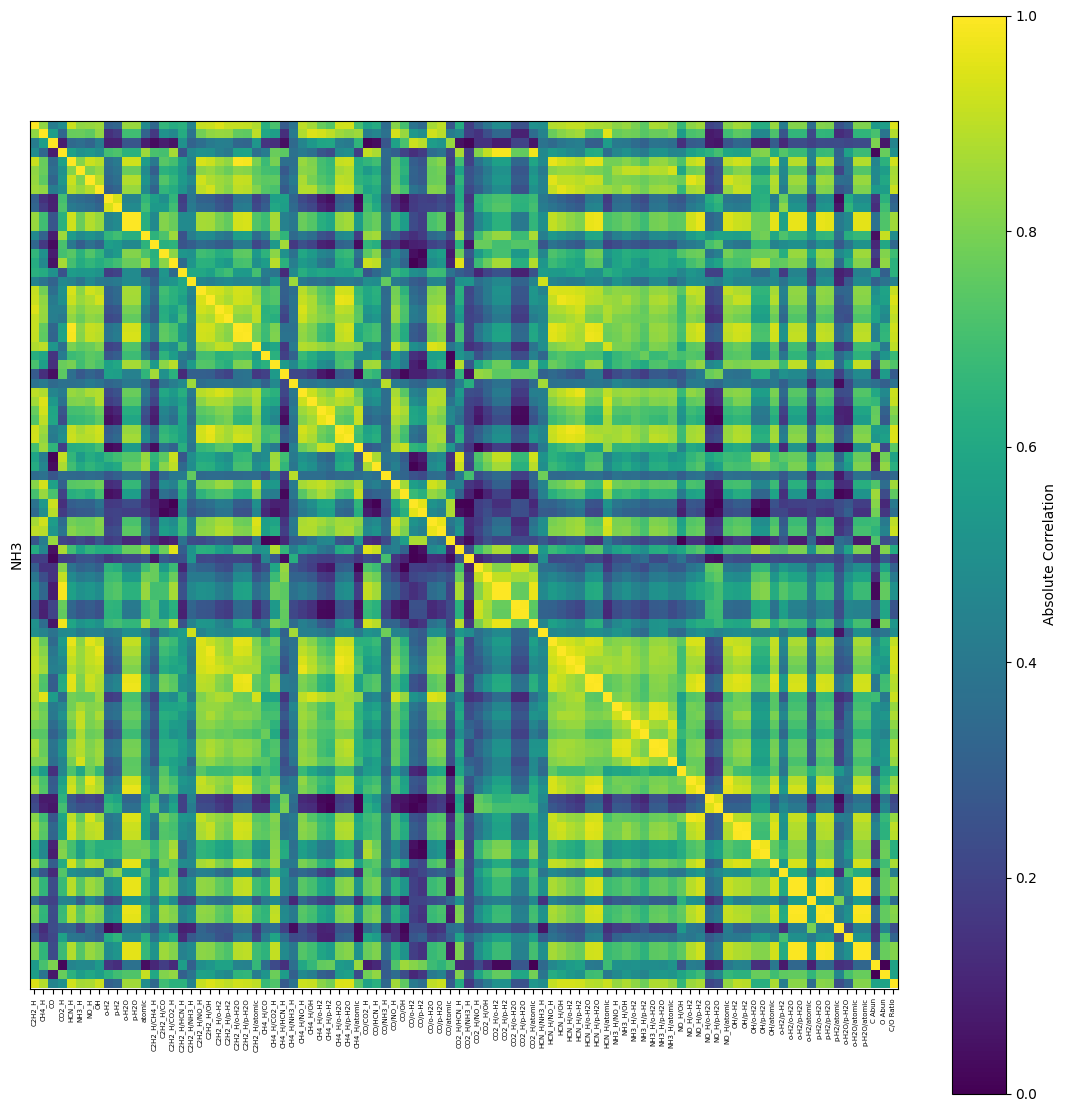

In [5]:
plt.close('all')
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'o-H2', 'p-H2', 'o-H2O', 'p-H2O',
           'atomic']
data = []
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row['ProDiMo Wavelength'], row[f'ProDiMo {specie}']))
    data.append(fluxes)

df_prodimo_flux = pd.DataFrame(data, columns=species)

for index, specie_1 in enumerate(species):
    for specie_2 in species[index+1:]:
        df_prodimo_flux[f'{specie_1}/{specie_2}'] =df_prodimo_flux[specie_1]/df_prodimo_flux[specie_2]
        
df_prodimo_flux['C Abun'] = df['C Value'].astype(float)
df_prodimo_flux['O Abun'] = df['O Value'].astype(float)
df_prodimo_flux['C/O Ratio'] = df['CO Value'].astype(float)

for specie in species:
    plt.figure(figsize=(4, 4))
    plt.imshow(df_prodimo_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    plt.show()

plt.figure(figsize=(14, 14))
plt.imshow(abs(df_prodimo_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(df_prodimo_flux.columns)), labels=df_prodimo_flux.columns, fontsize=5, rotation=90)
# plt.yticks(ticks=np.arange(len(df_prodimo_flux.columns)), labels=df_prodimo_flux.columns, fontsize=5)
plt.ylabel('NH3')
plt.yticks([])
plt.colorbar(label='Absolute Correlation')
plt.show()

In [ ]:
specie = 'C/O Ratio'
norm = plt.Normalize(0, 1)
cmap = plt.cm.viridis
columns = df_prodimo_flux.columns

fig, ax = plt.subplots(figsize=(8, 5))

for i, row in df_prodimo_flux.iterrows():
    ax.scatter(np.arange(len(columns[:len(species)])), row[:len(species)], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ax.set_xticks(np.arange(len(columns[:len(species)])))
ax.set_xticklabels(columns[:len(species)], rotation=90) 
ax.set_yscale('log')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$)]')
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('C/O')

plt.show()

# FLiTs

In [ ]:
plot_flits_specie('NH3')

In [ ]:
cmap = mpl.colormaps.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(14, 5))
species = ['atomic', 'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
model = df['Model Name'][12]

total_spec = None
FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
for index, specie in enumerate(species):
    specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    if total_spec is None:
        total_spec = new_specie_flux
    else:
        total_spec += new_specie_flux
    ax.fill_between(FLiTs_wl, 0, total_spec, label=specie, zorder=len(species) - index,
                    color=cmap(index / len(species)))
    
ax.plot(FLiTs_wl, FLiTs_flux, c='black', lw=2, label='FLiTs', zorder=0)

fig.suptitle(model)
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim([6, 8])
ax.set_ylim(-0.001,0.002)
ax.legend(loc='best')

plt.show()

In [ ]:
data = []
species = ['atomic', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'O2', 'OH']

for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
    
df_FLiTs_flux = pd.DataFrame(data, columns=species)

for index, specie_1 in enumerate(species):
    for specie_2 in species[index+1:]:
        df_FLiTs_flux[f'{specie_1}/{specie_2}'] =df_FLiTs_flux[specie_1]/df_FLiTs_flux[specie_2]
        
df_FLiTs_flux['C Abun'] = df['C Value'].astype(float)
df_FLiTs_flux['O Abun'] = df['O Value'].astype(float)
df_FLiTs_flux['C/O Ratio'] = df['CO Value'].astype(float)

for specie in species:
    plt.figure(figsize=(4, 4))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    plt.show()

plt.figure(figsize=(14, 14))
plt.imshow(df_FLiTs_flux.corr(method='kendall').loc[['NH3']], cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(df_FLiTs_flux.columns)), labels=df_FLiTs_flux.columns, fontsize=5, rotation=90)
# plt.yticks(ticks=np.arange(len(df_FLiTs_flux.columns)), labels=df_FLiTs_flux.columns, fontsize=5)
plt.ylabel('NH3')
plt.yticks([])
plt.colorbar(label='Absolute Correlation')
plt.show()

In [ ]:
specie = 'O Abun'
norm = plt.Normalize(df_FLiTs_flux[specie].min(), df_FLiTs_flux[specie].max())
# norm = plt.Normalize(0, 1)
cmap = plt.cm.viridis
columns = df_FLiTs_flux.columns

fig, ax = plt.subplots(figsize=(8, 5))

for i, row in df_FLiTs_flux.iterrows():
    ax.scatter(np.arange(len(columns[:len(species)])), row[:len(species)], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ax.set_xticks(np.arange(len(columns[:len(species)])))
ax.set_xticklabels(columns[:len(species)], rotation=90)
ax.set_ylim(1e-17, 1e-13)
ax.set_yscale('log')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$)]')
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('O Abun')

plt.show()

In [ ]:
plt.close('all')
specie = 'NH3'
for i in range(25):
    if df['O Value'][i] == '-0.5':
        color = 'red'
    elif df['O Value'][i] == '-0.25':
        color = 'orange'
    elif df['O Value'][i] == '0.0':
        color = 'green'
    elif df['O Value'][i] == '0.25':
        color = 'blue'
    elif df['O Value'][i] == '0.5':
        color = 'purple'
    plt.plot(df[f'FLiTs {specie} Wavelength'][i], df[f'FLiTs {specie} Flux'][i], color=color,
             label=f"O Abun: {df['O Value'][i]}")
    if i % 5 == 4:
        plt.title(f'C Abun {(i // 5) / 4 - 0.5}')
        plt.xlim(6, 6.31)
        plt.ylim(0, 0.00025)
        plt.xlabel(r'Wavelength ($\mu$m)')
        plt.ylabel('Flux (Jy)')
        plt.legend()
        plt.show()

In [ ]:
model = pread.read_prodimo('./models/C_0.0_O_0.0_CO_0.45')

In [ ]:
print(*[x for x in model.chemnet.reactions if "NH3" in x.products],sep="\n")